# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

**Описание данных**

1) Технологический процесс

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate — ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

2) Параметры этапов

- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

Наименование признаков

Наименование признаков должно быть такое:

***[этап].[тип_параметра].[название_параметра]***

*Пример: rougher.input.feed_ag*

Возможные значения для блока [этап]:

- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока [тип_параметра]:

- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

## Подготовка данных

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import ttest_ind

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, LinearRegression

from matplotlib.colors import LinearSegmentedColormap


In [2]:
data_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_train.csv', index_col='date')
data_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_test.csv', index_col='date')
data_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_full.csv', index_col='date')

In [3]:
data_test.columns

Index(['rougher.input.feed_au', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_sol',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_clea

In [4]:
data_full.shape

(19439, 86)

In [5]:
data_test.head(2)

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,-299.862743,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,-299.907308,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


In [6]:
data_test.shape

(4860, 52)

### 
Проверим, что эффективность обогащения рассчитана правильно. 
Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдём MAE между расчётами и значением признака.

![Формула эффективности обогащения](https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg)

- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

In [7]:
C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']

In [8]:
R = C * (F - T) / (F * (C - T)) * 100

In [9]:
mean_absolute_error(R, data_train['rougher.output.recovery']).round(100)

9.83758577644259e-15

Результат вычисления MAE почти равно нулю. Это может быть связанно с особенностями вычислений Python, а может вычисления изначально делались на более слабой машине. Можно считать вычисления Recovery верными.

In [10]:
R.describe().apply('{:0.2f}'.format)

count    14579.00
mean        82.52
std         15.80
min         -0.00
25%         80.56
50%         85.95
75%         89.96
max        100.00
dtype: object

In [11]:
data_train['rougher.output.recovery'].describe().apply('{:0.2f}'.format)

count    14579.00
mean        82.52
std         15.80
min          0.00
25%         80.56
50%         85.95
75%         89.96
max        100.00
Name: rougher.output.recovery, dtype: object

Основные статистики также равны.

### 
Проанализируем признаки, недоступные в тестовой выборке.

Признаки, которых нет в test_data

In [12]:
display(len(set(data_full.columns) - set(data_test.columns)))
set(data_full.columns) - set(data_test.columns)

34

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [13]:
missing_features = [i for i in data_train.columns if i not in data_test.columns]

Признаки, недоступные в тестовой выборке это выходные (output) и расчетные (calculation) характеристики. Значит, их нельзя использовать при обучении, так как они еще не будут доступны в моменте обработки руды.

### Предобоработка данных

Признаки почти идентичны по соседнему времени, можно заполнить их методом ffill

In [14]:
data_full = data_full.fillna(method='ffill')
data_train = data_train.fillna(method='ffill')
data_test = data_test.fillna(method='ffill')

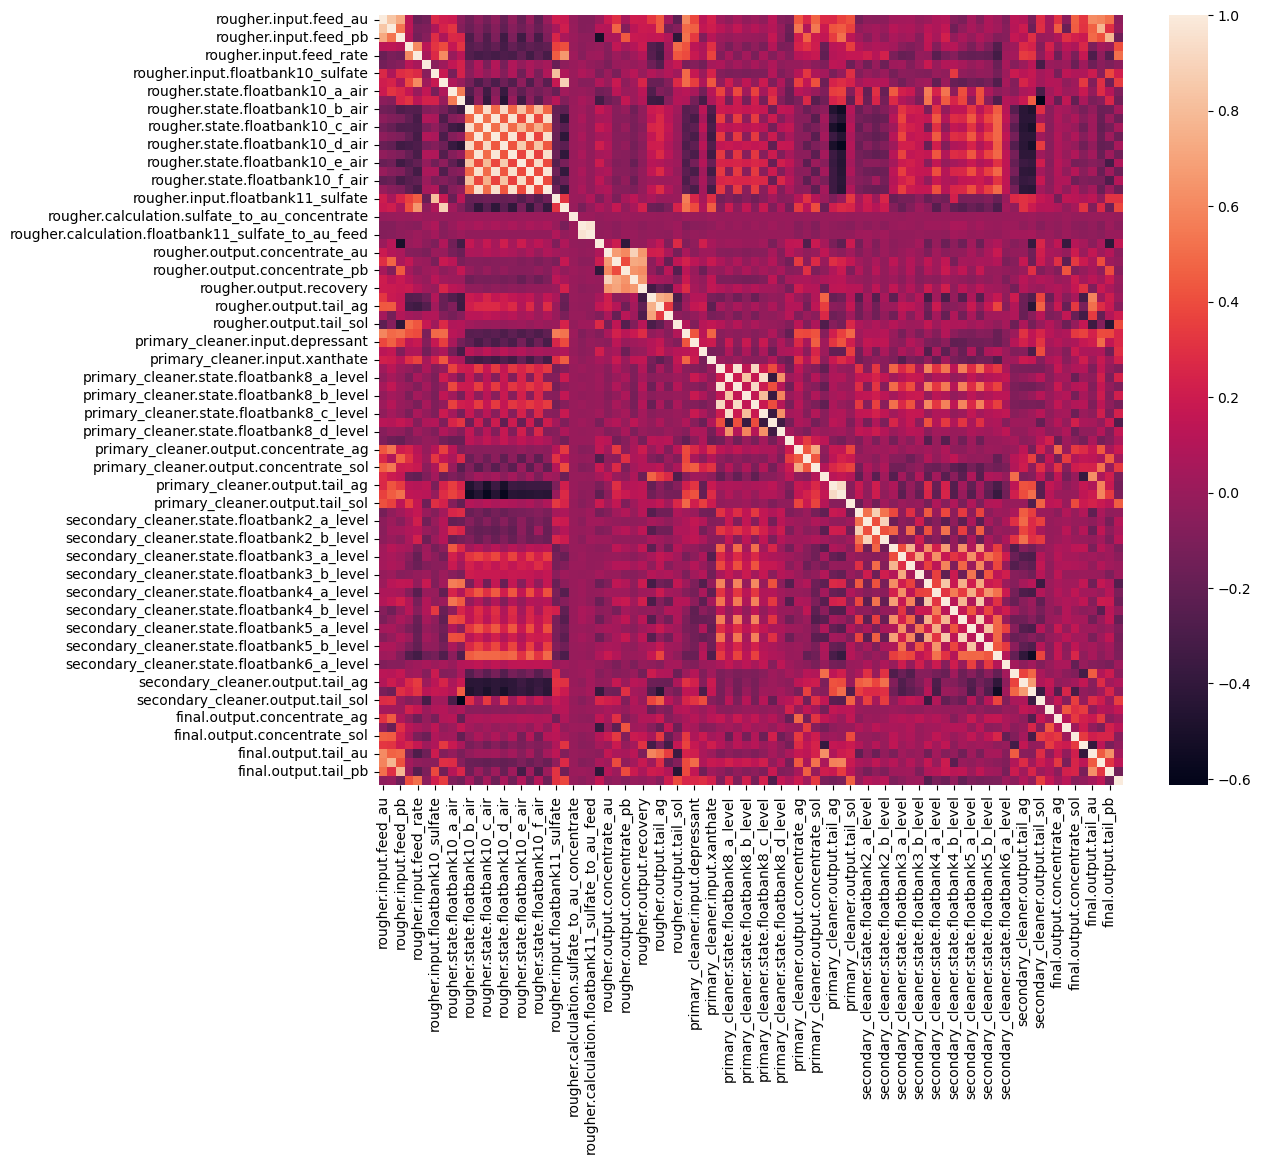

In [15]:
plt.figure(figsize=(12, 10))
sns.heatmap(data_train.corr());

Довольно много признаков значимо коррелируют на стадии флотации, в дальнейшем попробуем справится с мультиколлениарностью через PCA. Если линейные модели покажут себя хорошо.

## Анализ данных

### 
Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: 
в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

In [16]:
# Удалим аномальные значения концентраций:
data_train = data_train[(data_train['rougher.output.concentrate_au'] != 0) &
                    (data_train['rougher.output.concentrate_ag'] != 0) &
                    (data_train['rougher.output.concentrate_pb'] != 0)]

data_train = data_train[(data_train['primary_cleaner.output.concentrate_au'] != 0) &
                    (data_train['primary_cleaner.output.concentrate_ag'] != 0) &
                    (data_train['primary_cleaner.output.concentrate_pb'] != 0)]

data_train = data_train[(data_train['final.output.concentrate_au'] != 0) &
                    (data_train['final.output.concentrate_ag'] != 0) &
                    (data_train['final.output.concentrate_pb'] != 0)]

data_full = data_full[(data_full['rougher.output.concentrate_au'] != 0) &
                  (data_full['rougher.output.concentrate_ag'] != 0) &
                  (data_full['rougher.output.concentrate_pb'] != 0)]

data_full = data_full[(data_full['primary_cleaner.output.concentrate_au'] != 0) &
                    (data_full['primary_cleaner.output.concentrate_ag'] != 0) &
                    (data_full['primary_cleaner.output.concentrate_pb'] != 0)]

data_full = data_full[(data_full['final.output.concentrate_au'] != 0) &
                  (data_full['final.output.concentrate_ag'] != 0) &
                  (data_full['final.output.concentrate_pb'] != 0)]

Создадим список названий нужных фичей.

In [18]:
concentrate_features = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 
       'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
      'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb',
      'final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']
au_concentrate_features = data_full[concentrate_features[::3]].copy()
ag_concentrate_features = data_full[concentrate_features[1::3]].copy()
pb_concentrate_features = data_full[concentrate_features[2::3]].copy()

Создадим функцию, которая убирает редкие значения в наших данных.

In [19]:
def concentrate_framing(df, border):
    for col in df:
        # Вычисляем процентили для этого столбца
        lower, upper = df[col].quantile([border, 1 - border])

        # Удаляем строки, которые находятся за пределами этих процентилей
        df = df[(df[col] > lower) & (df[col] < upper)]
    return df

In [20]:
au_concentrate_features = concentrate_framing(au_concentrate_features, 0.01)
ag_concentrate_features = concentrate_framing(ag_concentrate_features, 0.01)
pb_concentrate_features = concentrate_framing(pb_concentrate_features, 0.01)

Построим графики распределений концентраций элементов на всех этапах.

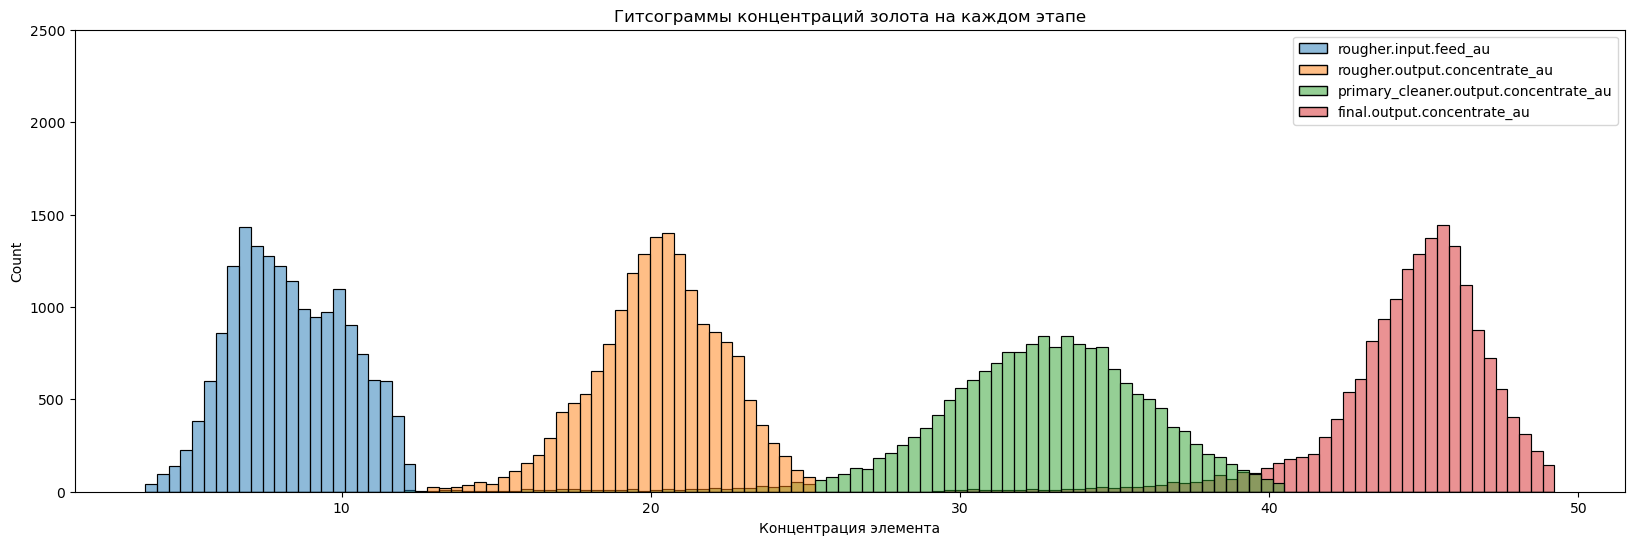

In [21]:
plt.figure(figsize=(20, 6))
sns.histplot(au_concentrate_features, bins=120)
plt.ylim(0, 2500)
plt.xlabel('Концентрация элемента')
plt.title('Гитсограммы концентраций золота на каждом этапе');

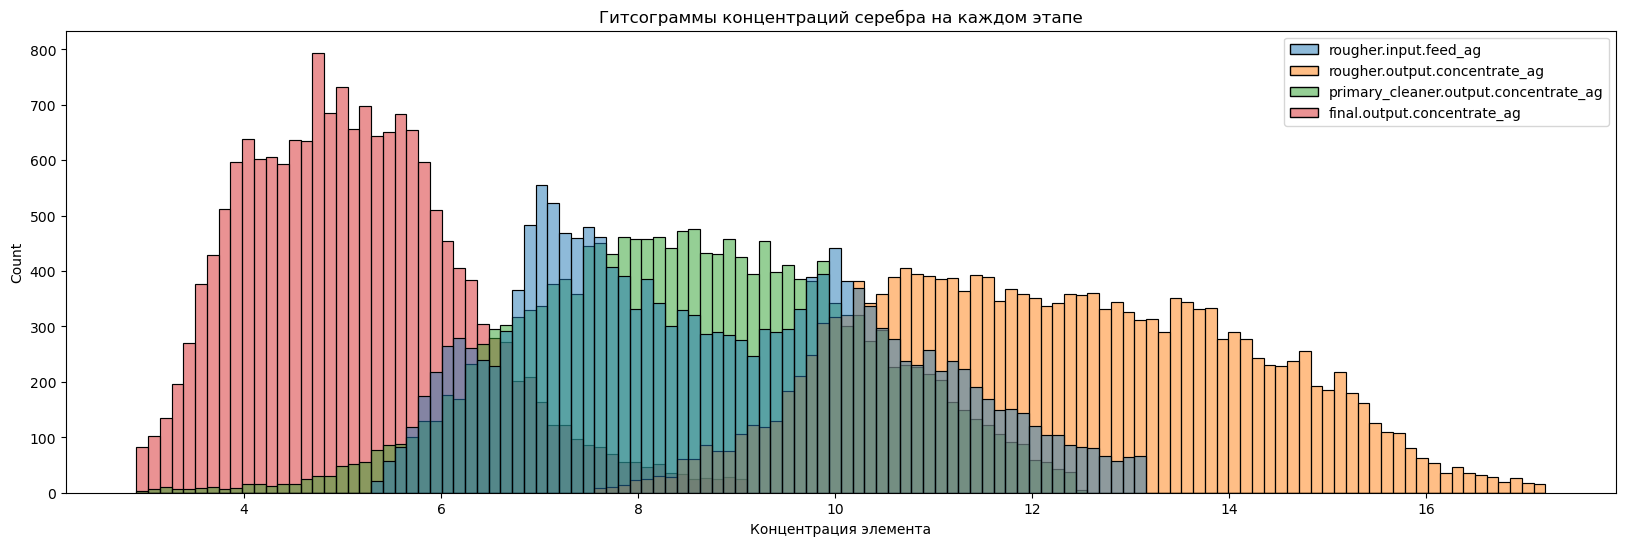

In [36]:
plt.figure(figsize=(20, 6))
sns.histplot(ag_concentrate_features, bins=120)
plt.xlabel('Концентрация элемента')
plt.title('Гитсограммы концентраций серебра на каждом этапе');

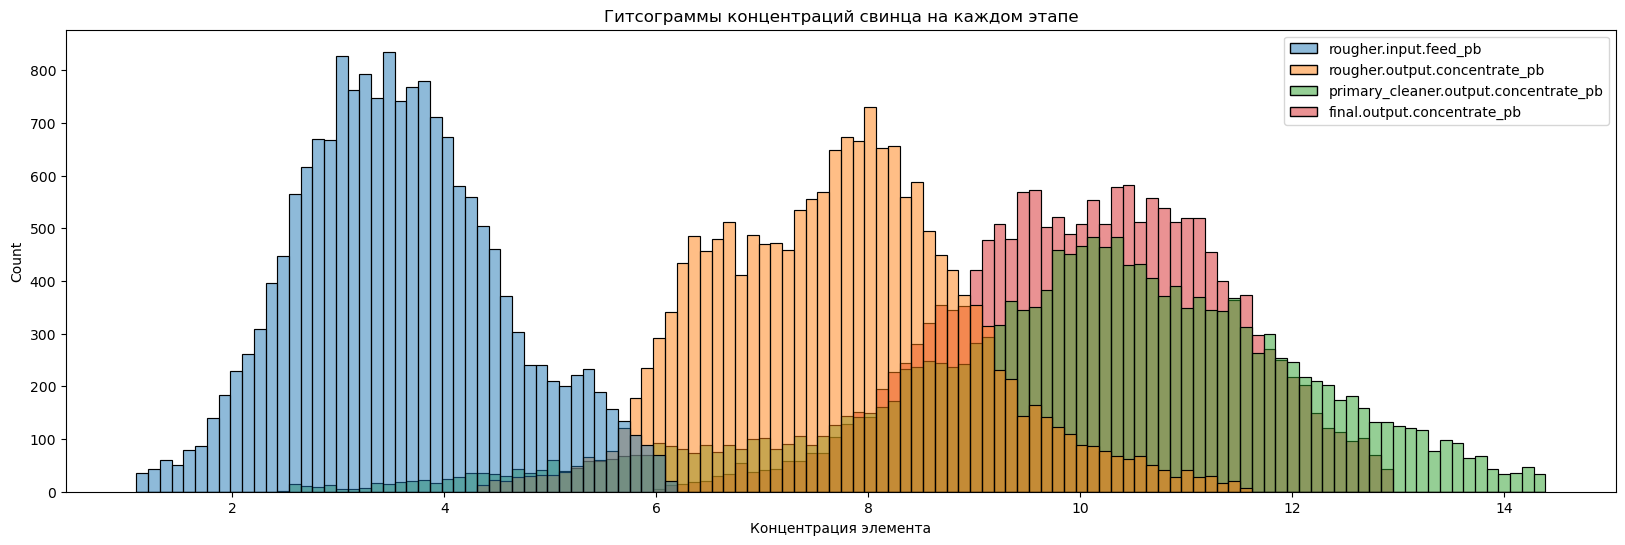

In [37]:
plt.figure(figsize=(20, 6))
sns.histplot(pb_concentrate_features, bins=120)
plt.xlabel('Концентрация элемента')
plt.title('Гитсограммы концентраций свинца на каждом этапе');

In [38]:
rougher_input_concentrate_features = data_full[concentrate_features[:3]].copy()
rougher_output_concentrate_features = data_full[concentrate_features[3:6]].copy()
primary_concentrate_features = data_full[concentrate_features[6:9]].copy()
final_concentrate_features = data_full[concentrate_features[9:]].copy()

In [39]:
rougher_input_concentrate_features = concentrate_framing(rougher_input_concentrate_features, 0.01)
rougher_output_concentrate_features = concentrate_framing(rougher_output_concentrate_features, 0.01)
primary_concentrate_features = concentrate_framing(primary_concentrate_features, 0.01)
final_concentrate_features = concentrate_framing(final_concentrate_features, 0.01)

Построим графики расперделений концентраций металлов на поэтапно.

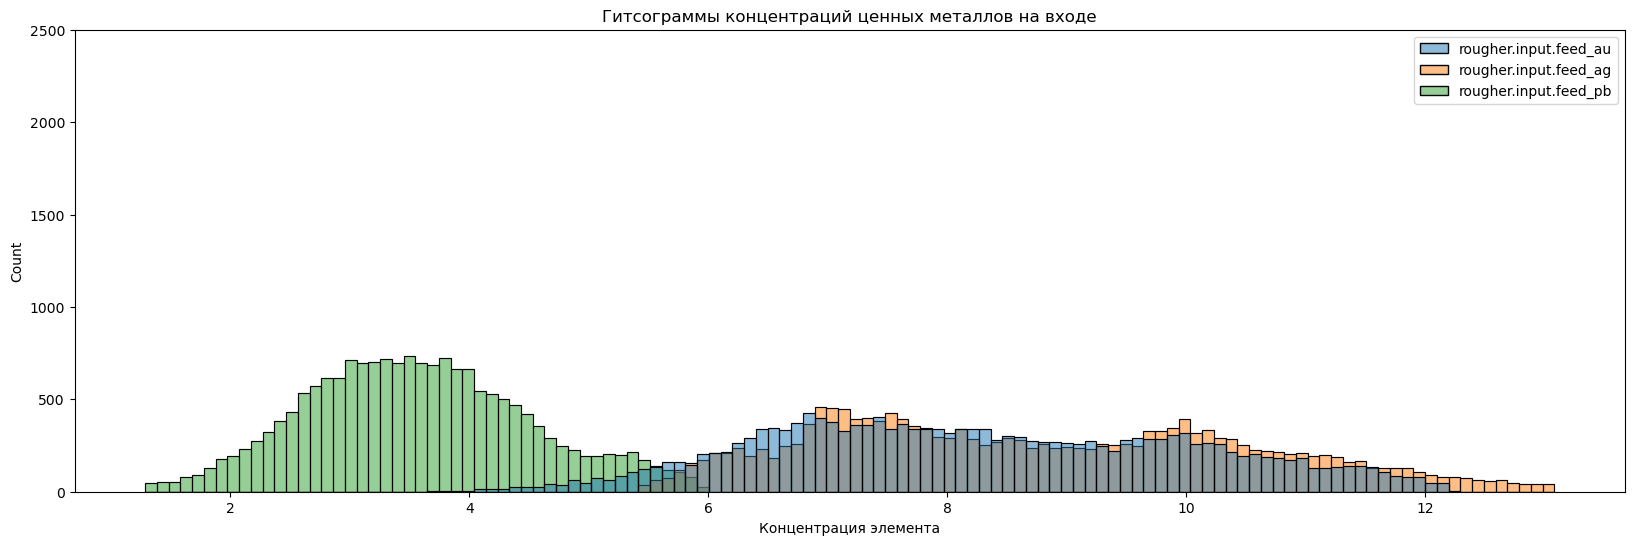

In [40]:
plt.figure(figsize=(20, 6))
sns.histplot(rougher_input_concentrate_features, bins=120)
plt.ylim(0, 2500)
plt.xlabel('Концентрация элемента')
plt.title('Гитсограммы концентраций ценных металлов на входе');

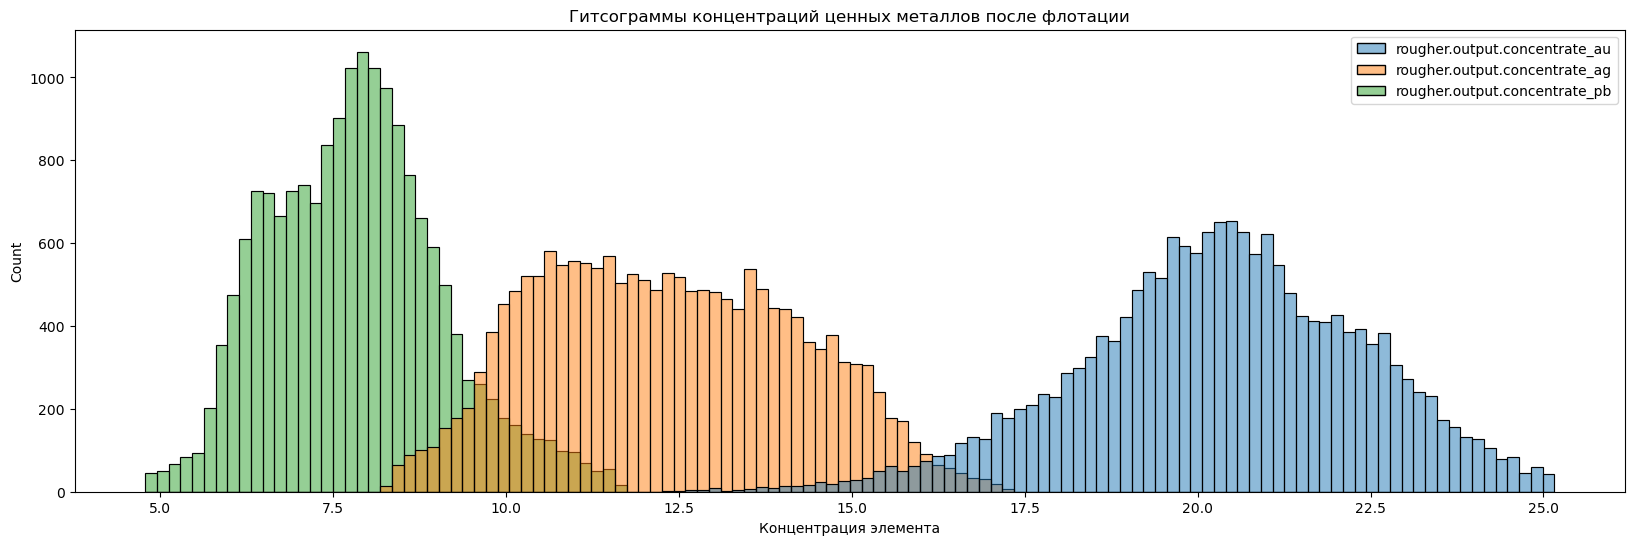

In [41]:
plt.figure(figsize=(20, 6))
sns.histplot(rougher_output_concentrate_features, bins=120)
plt.xlabel('Концентрация элемента')
plt.title('Гитсограммы концентраций ценных металлов после флотации');

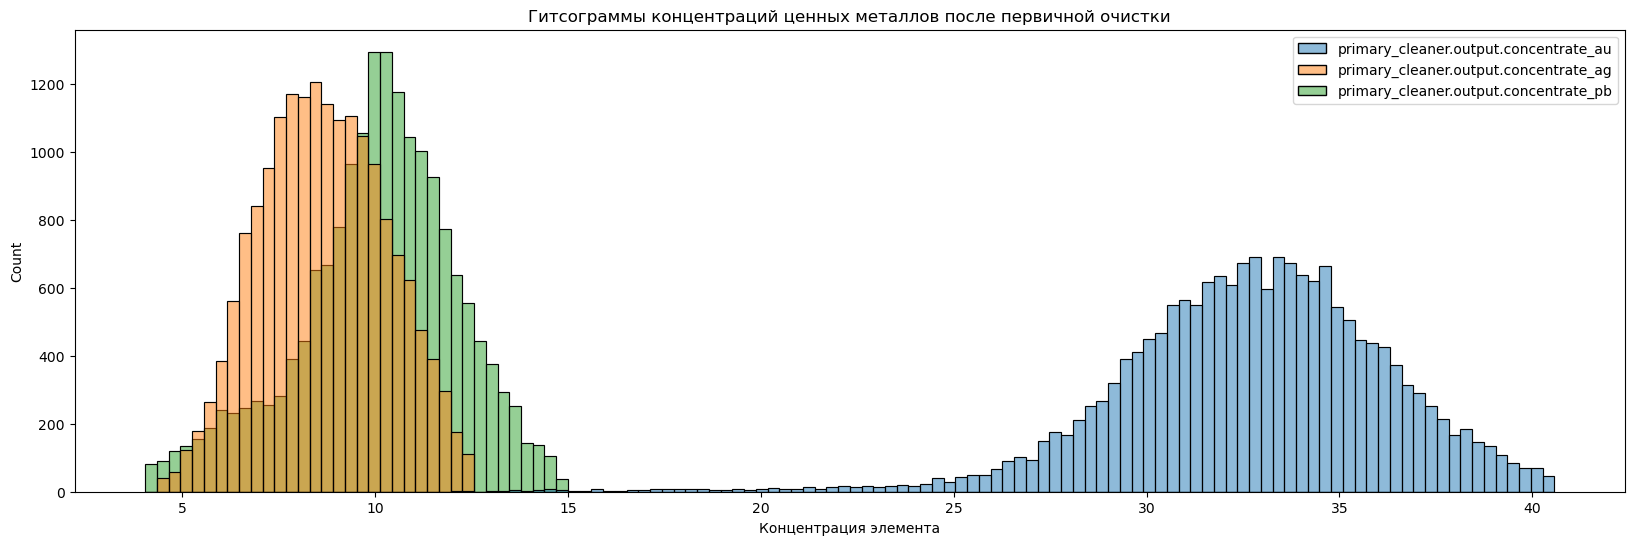

In [42]:
plt.figure(figsize=(20, 6))
sns.histplot(primary_concentrate_features, bins=120)
plt.xlabel('Концентрация элемента')
plt.title('Гитсограммы концентраций ценных металлов после первичной очистки');

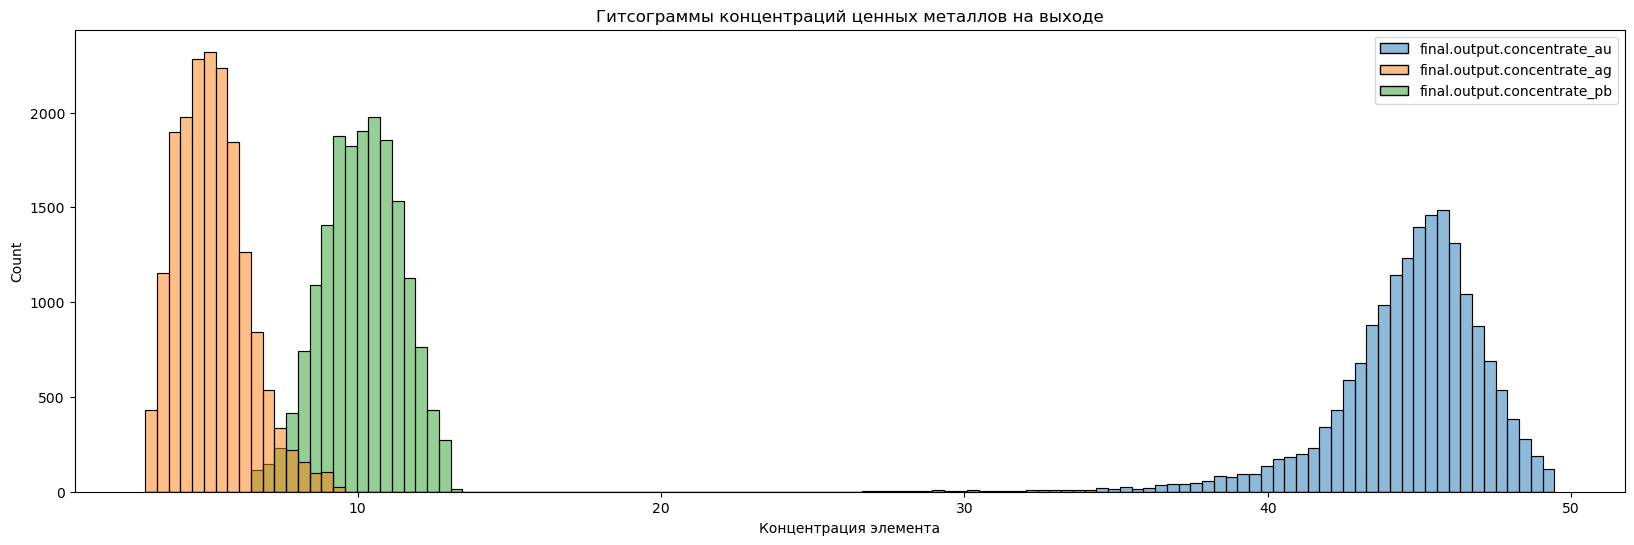

In [43]:
plt.figure(figsize=(20, 6))
sns.histplot(final_concentrate_features, bins=120)
plt.xlabel('Концентрация элемента')
plt.title('Гитсограммы концентраций ценных металлов на выходе');

1) При каждом этапе стабильно повышается концентрация золота в руде на 12-14%.

2) Все этапы процесса имею нормальное распределение с похожей дисперсией, за исключением первичной очистки, где наблюдается повышенная дисперсия, первичный этап очистки является наиболее плохо предсказуемом этапом.

3) Входе обогащения золота, концентрация серебра повышается после флотации, но падает после первичной очистки до уровня сырья, а после вторичной очистки падает ниже уровня входящих значений.

4) Концентрации свинца же улучшаются в 3 раза, но имею очень большую дисперсию после первичной и вторичной очистках.

5) На обогащение подают примерно одинаковое количество золота и серебра, и заметно ниже свинца.

6) После флотации все элементы повышают свою концентрацию и заметно теряют дисперсию. Сильнее всего после флотации повышается концентрация золота.

7) После первичной и вторичной очисток концентрации приобретают явные нормальные распределения с заметно меньшей дисперсией, чем было, что может быть сигналом, о более предсказуемом их поведении.

*Раз концентрации золота увеличиваются на каждом этапе, то глобальных проблем с процессами не наблюдается.*

### 
Сравним распределения размеров гранул исходного сырья на обучающей и тестовой выборках. 

Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

In [22]:
data_train['rougher.input.feed_size'].describe().apply('{:.2f}'.format)['std']

'23.08'

In [23]:
data_test['rougher.input.feed_size'].describe().apply('{:.2f}'.format)['std']

'19.51'

Дисперсии примерно равны.

С помощью т-теста определим равны ли средние этих выборок.

In [24]:
sample_train = data_train['rougher.input.feed_size'].dropna()
sample_test = data_test['rougher.input.feed_size'].dropna()

alpha = 0.01

result = ttest_ind(sample_train, sample_test, equal_var=True).pvalue

if result > alpha:
    print(f'Средние выборок равны. pvalue = {result}')
else:
    print(f'Средние выборок не равны. pvalue = {result}')

Средние выборок равны. pvalue = 0.9233782195495766


Построим график плотности и box-plot-ы данных размеров частиц.

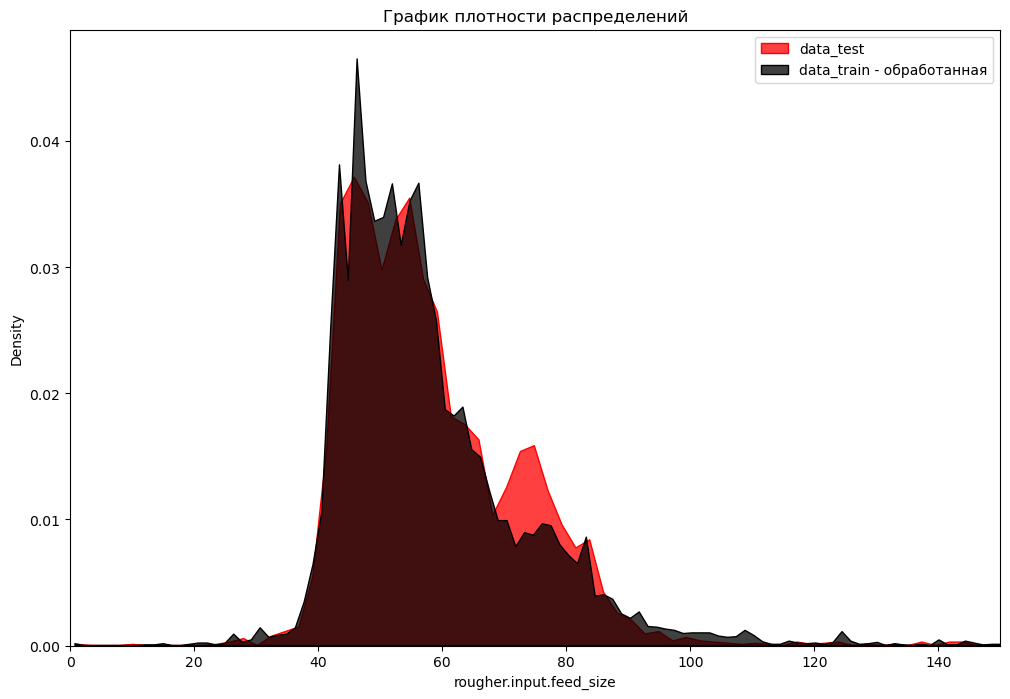

In [26]:
plt.figure(figsize=(12, 8))
sns.histplot(data_test['rougher.input.feed_size'], color='red', element="poly", stat='density')
sns.histplot(data_train['rougher.input.feed_size'], color='black', element="poly", stat='density')
plt.legend(['data_test', 'data_train - обработанная'])
plt.xlim([0, 150])
plt.title('График плотности распределений');

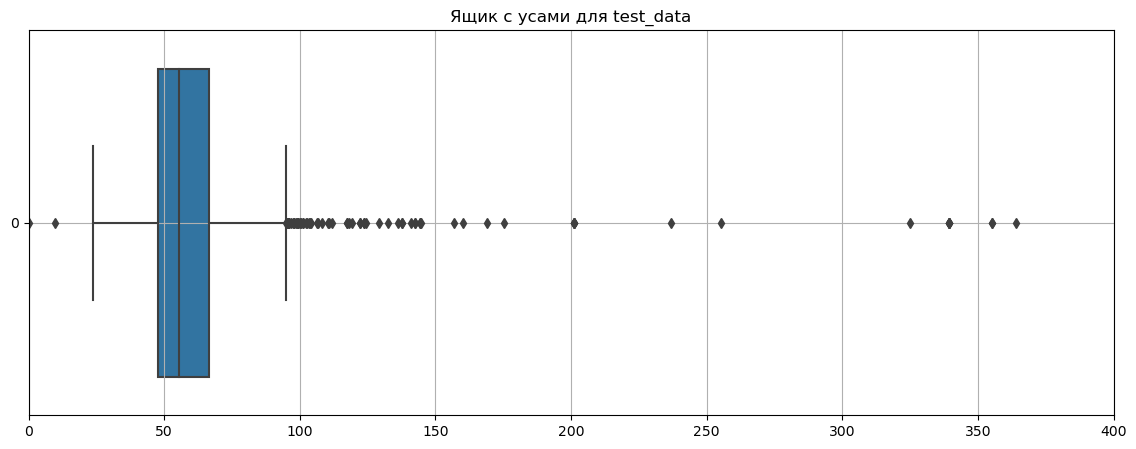

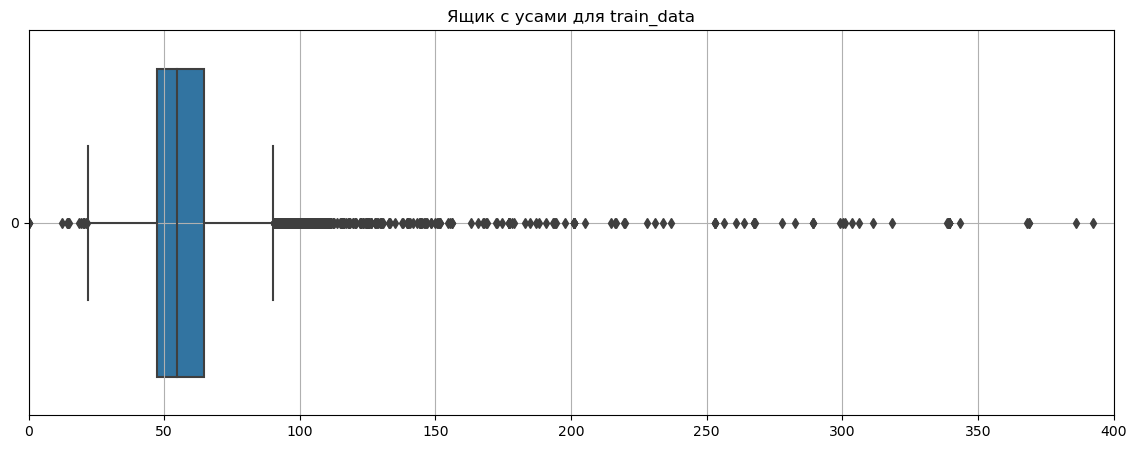

In [28]:
plt.figure(figsize=(14, 5))
sns.boxplot(data=data_test['rougher.input.feed_size'], orient='h')
plt.grid(True)
plt.xlim([0, 400])
plt.title('Ящик с усами для test_data')
plt.show();

plt.figure(figsize=(14, 5))
sns.boxplot(data=data_train['rougher.input.feed_size'], orient='h')
plt.grid(True)
plt.xlim([0, 400])
plt.title('Ящик с усами для train_data')
plt.show();

In [29]:
data_train['rougher.input.feed_size'].describe().apply('{:.2f}'.format)

count    13982.00
mean        59.17
std         23.08
min          0.05
25%         47.37
50%         54.59
75%         64.53
max        484.97
Name: rougher.input.feed_size, dtype: object

In [30]:
data_test['rougher.input.feed_size'].describe().apply('{:.2f}'.format)

count    4860.00
mean       59.14
std        19.51
min         0.05
25%        47.61
50%        55.46
75%        66.54
max       363.99
Name: rougher.input.feed_size, dtype: object

Распределения очень похожи, на сырых данных среднее тестом и трейном 59.17 и 59.14 и стандартными откланениями в 23.08 и 19.51.


### 
Исследуум суммарную концентрацию металлов на разных стадиях: 

- в сырье
- в черновом концентрате
- в концентрате после первой очистки
- в финальном концентрате

In [31]:
rougher_input_me = data_full[['rougher.input.feed_au', 
                              'rougher.input.feed_ag', 
                              'rougher.input.feed_pb']].sum(axis=1)

rougher_output_me = data_full[['rougher.output.concentrate_au', 
                               'rougher.output.concentrate_ag', 
                               'rougher.output.concentrate_pb']].sum(axis=1)

primary_me = data_full[['primary_cleaner.output.concentrate_au', 
                        'primary_cleaner.output.concentrate_ag', 
                        'primary_cleaner.output.concentrate_pb']].sum(axis=1)

final_me = data_full[['final.output.concentrate_au', 
                        'final.output.concentrate_ag', 
                        'final.output.concentrate_pb']].sum(axis=1)

In [32]:
summ_me_df = pd.DataFrame([rougher_input_me, rougher_output_me, primary_me, final_me]).T

In [33]:
summ_me_df.columns = ['rougher_input_me', 'rougher_output_me', 'primary_cleaning_me', 'final_me']

In [34]:
summ_me_df = concentrate_framing(summ_me_df, 0.01)

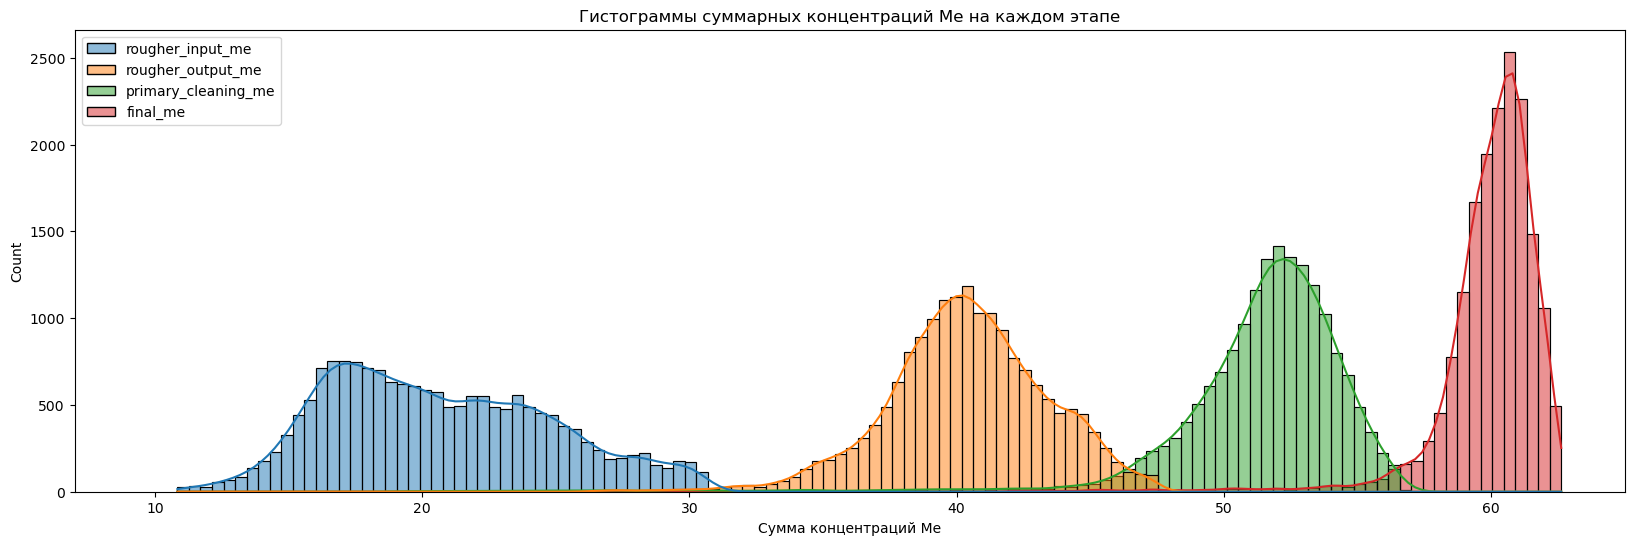

In [35]:
plt.figure(figsize=(20, 6))
sns.histplot(summ_me_df, bins=120, kde=True)
plt.xlabel('Сумма концентраций Ме')
plt.title(f'Гистограммы суммарных концентраций Ме на каждом этапе')
plt.xlim([7, 65]);

In [36]:
R.describe().apply('{:0.2f}'.format)

count    14579.00
mean        82.52
std         15.80
min         -0.00
25%         80.56
50%         85.95
75%         89.96
max        100.00
dtype: object

In [37]:
for col in summ_me_df:
    print(f'Статистики для {col}')
    display(summ_me_df[col].describe().apply('{:.2f}'.format)[1:])
    print('_' * 40)

Статистики для rougher_input_me


mean    20.65
std      4.17
min     10.84
25%     17.31
50%     20.12
75%     23.70
max     30.72
Name: rougher_input_me, dtype: object

________________________________________
Статистики для rougher_output_me


mean    40.38
std      2.99
min     26.25
25%     38.61
50%     40.37
75%     42.32
max     47.53
Name: rougher_output_me, dtype: object

________________________________________
Статистики для primary_cleaning_me


mean    51.29
std      3.83
min     18.79
25%     50.24
50%     51.93
75%     53.33
max     56.61
Name: primary_cleaning_me, dtype: object

________________________________________
Статистики для final_me


mean    59.95
std      2.02
min     42.09
25%     59.34
50%     60.31
75%     61.07
max     62.62
Name: final_me, dtype: object

________________________________________


После каждого этапа суммарная концентрация повышается, в среднем разброс значений уменьшается после каждого этапа.

Поэтапная динамика среднего значения: *20,65* => *40.38* => *51.29* => *59.95*

Наибольший эффект по увеличению суммарных концентраций даёт флотация (увеличение на 100%), затем первичная очистка (увеличение на 25%) затем вторчиная (увеличение на 17%).

Общее увеличение суммарных концентраций происходит в 3 раза.

Поэтапные изменения стандартного отклонения : *4.17* => *2.99* => *3.83* => *2.02*

*Изменения стандартного отклонения нелинейны, после первой очистки стандартное отклонение повышается, что может говорить об неочень хорошо прогнозируемом процессе.*

## Модель

Определим в функциях sMAPE метрику и итоговый sMAPE

In [38]:
# Функция для вычисления sMAPE
def smape(target, predictions):
    numerator = np.abs(target-predictions)
    denominator =(np.abs(target)+np.abs(predictions))/2
    div_output = np.divide(numerator, denominator)
    output_scores = np.average(div_output[denominator != 0], axis=0)
    
    return output_scores * 100

In [39]:
# Функция для вычисления итоговой sMAPE
def final_smape(rougher_smape, cleaner_smape): 
    return 0.25 * rougher_smape + 0.75 * cleaner_smape

Создадим "оценщик" для будущего подбора моделей.

In [40]:
smape_score = make_scorer(smape, greater_is_better=False)

Определим признаки для этапа флотации и для этапа очистки.

In [43]:
features_train = data_train.drop(missing_features, axis=1)
target_train = data_train[['rougher.output.recovery', 'final.output.recovery']]

features_test = data_test
target_test = data_full[data_full.index.isin(data_test.index)][['rougher.output.recovery', 'final.output.recovery']]

Создадим маски для этапа флотации и этапа очистки.

In [53]:
rougher_column = [col for col in features_train.columns if col.split('.')[0] == 'rougher']

cleaner_column = [col for col in features_train.columns if (col.split('.')[0] == 'primary_cleaner')
                                                          or (col.split('.')[0] == 'secondary_cleaner')]

In [58]:
features_train_rougher = features_train[rougher_column]
target_train_rougher = target_train['rougher.output.recovery']

features_train_cleaner = features_train[cleaner_column]
target_train_cleaner = target_train['final.output.recovery']

features_test_rougher = features_test[rougher_column]
target_test_rougher = target_test['rougher.output.recovery']

features_test_cleaner = features_test[cleaner_column]
target_test_cleaner = target_test['final.output.recovery']

# Проверим все ли фичи были разделены:
set(features_train.columns) - set(features_train_rougher.columns) - set(features_train_cleaner.columns)

set()

Создадим константную модель, для проверки нашей будущей модели на адекватность.

In [59]:
dummy_model_cleaner = DummyRegressor(strategy='mean') 
dummy_model_cleaner.fit(features_train_cleaner, target_train_cleaner)
dummy_smape_cleaner = smape(target_train_cleaner, dummy_model_cleaner.predict(features_train_cleaner))
dummy_smape_cleaner

9.795929083013647

In [60]:
dummy_model_rougher = DummyRegressor(strategy='mean') 
dummy_model_rougher.fit(features_train_rougher, target_train_rougher)
dummy_smape_rougher = smape(target_train_rougher, dummy_model_rougher.predict(features_train_rougher))
dummy_smape_rougher

6.930616200531323

In [61]:
final_dummy_smape = final_smape(dummy_smape_rougher, dummy_smape_cleaner)
final_dummy_smape

9.079600862393066

Итоговый sMAPE для константной модели равен `9.079`

### Подбор наилучей модели для этапа флотации

Создадим константное значение random_state

In [62]:
R_SEED = 32

Создадим pipline и отельные значения параметров для линейных моделей и для лесов.

In [63]:
pipeline = Pipeline([('scaler', RobustScaler()), ('model', LinearRegression())])

In [66]:
# Зададим параметры для линейных моделей
lin_params = [
    {
        'model': [Ridge()],
        'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
        'model__alpha': np.linspace(start = 0.01, stop = 5, num = 30),
        'model__normalize': [True, False]
    },
    {
        'model': [Lasso()],
        'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
        'model__alpha': np.linspace(start = 0.01, stop = 5, num = 30),
        'model__normalize': [True, False]
    }]

In [68]:
# Зададим параметры для моделей деревьев
tree_params = [

    {
        'model': [DecisionTreeRegressor(random_state=R_SEED)],
        'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
        'model__splitter': ['best', 'random'],
        'model__max_depth': [None] + [int(x) for x in np.linspace(start = 2, stop = 14, num = 10)],
        'model__max_features': ['auto', 'sqrt', 'log2']
    },
    {
        'model': [RandomForestRegressor(random_state=R_SEED)],
        'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
        'model__n_estimators': [int(x) for x in np.linspace(start = 50, stop = 150, num = 25)],
        'model__max_depth': [None] + [int(x) for x in np.linspace(start = 2, stop = 20, num = 15)],
        'model__min_samples_leaf': [int(x) for x in np.linspace(start = 2, stop = 600, num = 50)],
        'model__max_features':  ['auto', 'sqrt', 'log2']   
    },
]

In [69]:
kf = KFold(n_splits=3, shuffle=True, random_state=R_SEED)

Ниалучшие параметры будем искать с помощью randomized search.

In [71]:
# RandomizedSearchCV для линейных моделей
random_search_line = RandomizedSearchCV(pipeline, lin_params, cv=kf, scoring=smape_score, n_jobs=-1, 
                                   n_iter=100, verbose=10, random_state=R_SEED)

In [72]:
# RandomizedSearchCV для леса
random_search_tree = RandomizedSearchCV(pipeline, tree_params, cv=kf, scoring=smape_score, n_jobs=-1, 
                                   n_iter=100, verbose=10, random_state=R_SEED)

In [199]:
%%time
random_search_tree.fit(features_train_rougher, target_train_rougher)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Wall time: 1min


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=32, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('model', LinearRegression())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'model': [DecisionTreeRegressor(random_state=32)],
                                         'model__max_depth': [None, 2, 3, 4, 6,
                                                              7, 8, 10, 11, 12,
                                                              14],
                                         'model__max_features': ['auto', 'sqrt',
                                                                 'log2'],
                                         'model__spl...
                                                                     75, 87, 99,
                                                                     111, 124,
                                             

In [200]:
%%time
random_search_line.fit(features_train_rougher, target_train_rougher)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Wall time: 1.67 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=32, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('model', LinearRegression())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'model': [Ridge(alpha=3.1072413793103446,
                                                         normalize=False)],
                                         'model__alpha': array([0.01      , 0.18206897, 0.35413793, 0.5262069 , 0.69827586,
       0.87034483, 1.04241379, 1.214...
       1.73068966, 1.90275862, 2.07482759, 2.24689655, 2.41896552,
       2.59103448, 2.76310345, 2.93517241, 3.10724138, 3.27931034,
       3.45137931, 3.62344828, 3.79551724, 3.96758621, 4.13965517,
       4.31172414, 4.4837931 , 4.65586207, 4.82793103, 5.        ]),
                                         'model__normalize': [True, False],
                                         'scaler': [None, Standard

Создадим dataframe для просмотра качества линейных моделей от гипперпараметров

In [201]:
cv_data_lin = pd.DataFrame(random_search_line.cv_results_)[['param_model',
                                                            'param_scaler', 
                                                            'param_model__normalize', 
                                                            'param_model__alpha', 
                                                            'mean_test_score']]
cv_data_lin['mean_test_score'] = abs(cv_data_lin['mean_test_score'])

Выведем топ 10 лучших оценок

In [202]:
cv_data_lin.sort_values(by='mean_test_score').head(10).mean_test_score

90    4.887644
10    4.887695
73    4.887811
11    4.887857
40    4.887868
91    4.887905
24    4.887930
5     4.887953
74    4.888017
46    4.888019
Name: mean_test_score, dtype: float64

Оценки распределены равномерно.

Сделаем то же для моделей лесов.

In [203]:
cv_data_tree = pd.DataFrame(random_search_tree.cv_results_)[['param_model',
                                                             'param_scaler', 
                                                            'param_model__n_estimators', 
                                                            'param_model__min_samples_leaf', 
                                                            'param_model__max_features',
                                                            'param_model__max_depth',
                                                            'mean_test_score']]
cv_data_tree['mean_test_score'] = abs(cv_data_tree['mean_test_score'])

In [204]:
cv_data_tree.sort_values(by='mean_test_score').head(10).mean_test_score

98    3.097390
83    3.571945
18    3.604044
34    3.859355
27    3.939026
84    3.948143
30    3.948420
23    3.949074
17    3.952704
2     4.019947
Name: mean_test_score, dtype: float64

Первая оценка сильно отличается от остальных, скорее всего данные удачно совпали и эта модель переобучена.

В среднем модели лесов показали лучшие значения sMAPE, разбирём их поподробнее.

In [205]:
cv_data_tree['param_model'] = cv_data_tree['param_model'].astype('str')
cv_data_tree['param_scaler'] = cv_data_tree['param_scaler'].astype('str')

Нарисуем столбчатые диаграммы средних оценок sMAPE от Дерева решений до Случайного леса и размаркируем scalers.

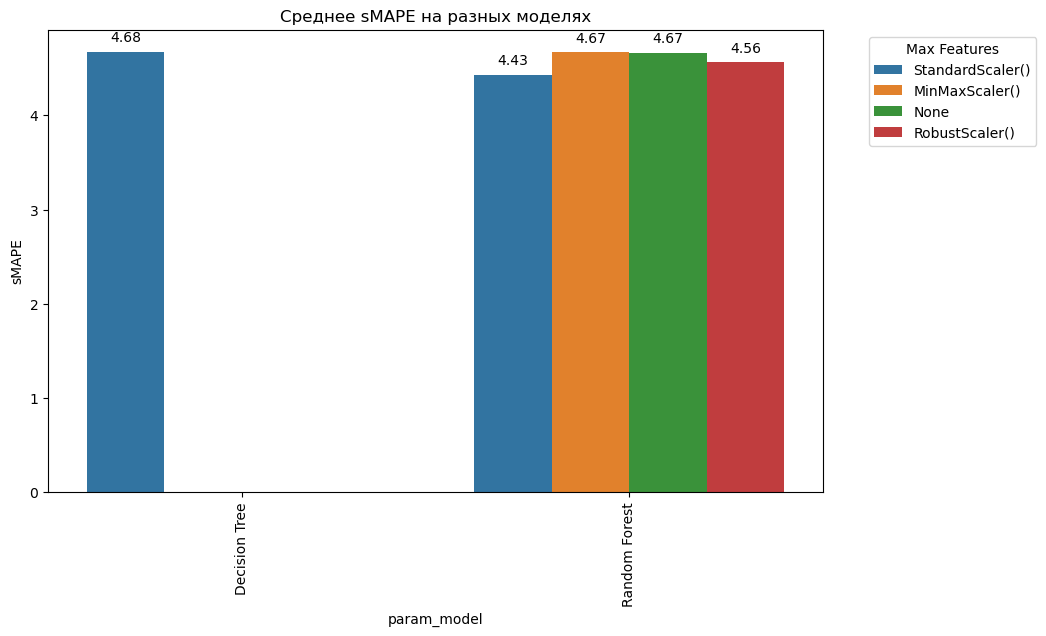

In [206]:
grouped_data = cv_data_tree.groupby(['param_model', 'param_scaler'])['mean_test_score'].mean().reset_index()

Forest_name = grouped_data.loc[1, 'param_model']
Tree_name = grouped_data.loc[0, 'param_model']

grouped_data['param_model'] = grouped_data['param_model'].replace({
                                                                    Forest_name : 'Random Forest',
                                                                    Tree_name : 'Decision Tree',
                                                                    })

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=grouped_data, x='param_model', y='mean_test_score', hue='param_scaler')

for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')

plt.title('Среднее sMAPE на разных моделях')
plt.ylabel('sMAPE')
plt.xticks(rotation=90)
plt.legend(title='Max Features', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

В среднем лучше всего показывает модель случайного леса со StandardScaler

In [207]:
cv_data_tree = cv_data_tree[(cv_data_tree.param_model == Forest_name) 
                            & (cv_data_tree.param_scaler == 'StandardScaler()')].drop(['param_model', 'param_scaler'], axis=1)

In [208]:
cv_data_tree.sort_values(by='mean_test_score').head(20)

,param_model__n_estimators,param_model__min_samples_leaf,param_model__max_features,param_model__max_depth,mean_test_score
98,83,2,auto,12,3.097390
83,150,2,sqrt,9,3.571945
34,79,50,log2,14,3.859355
30,120,63,sqrt,13,3.948420
2,137,75,log2,11,4.019947
56,120,75,sqrt,17,4.020051
31,137,148,auto,17,4.251778
69,125,148,log2,12,4.304972
13,75,160,sqrt,9,4.354205
15,129,209,sqrt,14,4.463980


In [209]:
best_rougth_model = random_search_tree.best_estimator_

In [210]:
rougth_model_smape = random_search_tree.best_score_

### Подбор наилучей модели для этапа очистки

Обучим те же randomized search на данных об очистке

In [211]:
%%time
random_search_tree.fit(features_train_cleaner, target_train_cleaner)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Wall time: 1min 21s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=32, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('model', LinearRegression())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'model': [DecisionTreeRegressor(random_state=32)],
                                         'model__max_depth': [None, 2, 3, 4, 6,
                                                              7, 8, 10, 11, 12,
                                                              14],
                                         'model__max_features': ['auto', 'sqrt',
                                                                 'log2'],
                                         'model__spl...
                                                                     75, 87, 99,
                                                                     111, 124,
                                             

In [212]:
%%time
random_search_line.fit(features_train_cleaner, target_train_cleaner)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Wall time: 2.05 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=32, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('model', LinearRegression())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'model': [Ridge(alpha=1.0424137931034483,
                                                         normalize=False)],
                                         'model__alpha': array([0.01      , 0.18206897, 0.35413793, 0.5262069 , 0.69827586,
       0.87034483, 1.04241379, 1.214...
       1.73068966, 1.90275862, 2.07482759, 2.24689655, 2.41896552,
       2.59103448, 2.76310345, 2.93517241, 3.10724138, 3.27931034,
       3.45137931, 3.62344828, 3.79551724, 3.96758621, 4.13965517,
       4.31172414, 4.4837931 , 4.65586207, 4.82793103, 5.        ]),
                                         'model__normalize': [True, False],
                                         'scaler': [None, Standard

Создадим датафреймы и выведем топ 10 лучших оценок для линейных моделей и для лесов

In [213]:
cv_data_lin = pd.DataFrame(random_search_line.cv_results_)[['param_model',
                                                            'param_scaler', 
                                                            'param_model__normalize', 
                                                            'param_model__alpha', 
                                                            'mean_test_score']]
cv_data_lin['mean_test_score'] = abs(cv_data_lin['mean_test_score'])
cv_data_lin.sort_values(by='mean_test_score').head(10).mean_test_score

21    8.357046
42    8.357387
78    8.357419
41    8.357959
80    8.358483
52    8.359597
40    8.359692
14    8.359756
90    8.359786
10    8.359840
Name: mean_test_score, dtype: float64

In [214]:

cv_data_tree = pd.DataFrame(random_search_tree.cv_results_)[['param_model',
                                                             'param_scaler', 
                                                            'param_model__n_estimators', 
                                                            'param_model__min_samples_leaf', 
                                                            'param_model__max_features',
                                                            'param_model__max_depth',
                                                            'mean_test_score']]
cv_data_tree['mean_test_score'] = abs(cv_data_tree['mean_test_score'])
cv_data_tree.sort_values(by='mean_test_score').head(10).mean_test_score

98    6.595777
83    6.998948
18    7.020646
27    7.290433
34    7.322823
30    7.364381
84    7.365957
23    7.376999
17    7.421529
56    7.450729
Name: mean_test_score, dtype: float64

Модели с деревьями показали лучшие оценки, взглянем на них поподробнее.

In [215]:
cv_data_tree['param_model'] = cv_data_tree['param_model'].astype('str')
cv_data_tree['param_scaler'] = cv_data_tree['param_scaler'].astype('str')

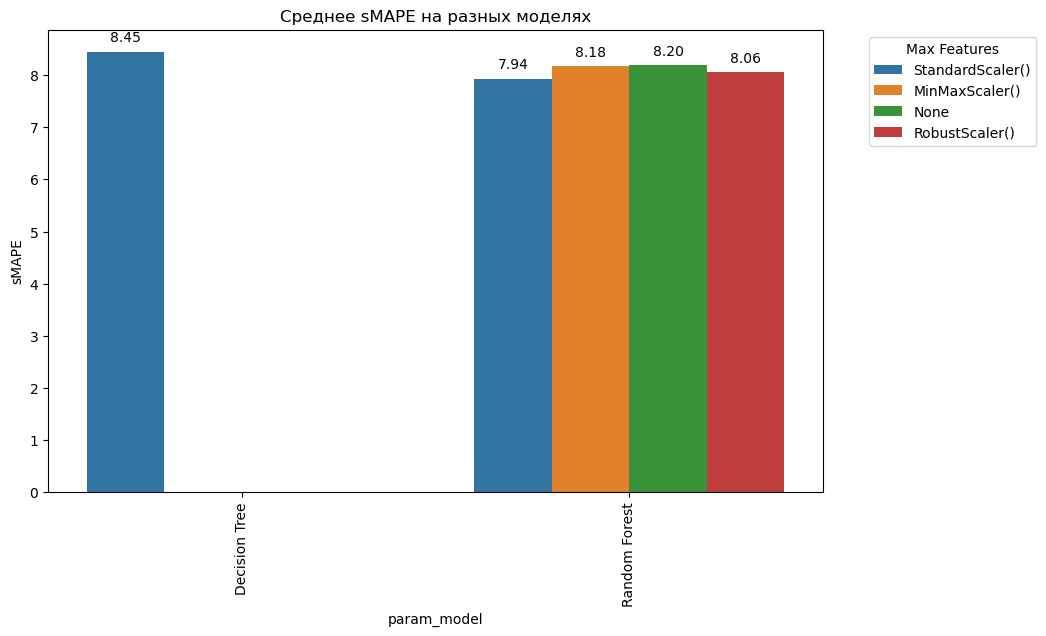

In [216]:
grouped_data = cv_data_tree.groupby(['param_model', 'param_scaler'])['mean_test_score'].mean().reset_index()

Forest_name = grouped_data.loc[1, 'param_model']
Tree_name = grouped_data.loc[0, 'param_model']

grouped_data['param_model'] = grouped_data['param_model'].replace({
                                                                    Forest_name : 'Random Forest',
                                                                    Tree_name : 'Decision Tree',
                                                                    })
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=grouped_data, x='param_model', y='mean_test_score', hue='param_scaler')

for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')

plt.title('Среднее sMAPE на разных моделях')
plt.ylabel('sMAPE')
plt.xticks(rotation=90)
plt.legend(title='Max Features', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Лучшей моделью по средним оценкам является Random Forest с StandardScaler 

In [217]:
cv_data_tree = cv_data_tree[(cv_data_tree.param_model == Forest_name) 
            & (cv_data_tree.param_scaler == 'StandardScaler()')].drop(['param_model', 'param_scaler'], axis=1)

In [218]:
cv_data_tree.sort_values(by='mean_test_score').head(10)

,param_model__n_estimators,param_model__min_samples_leaf,param_model__max_features,param_model__max_depth,mean_test_score
98,83,2,auto,12,6.595777
83,150,2,sqrt,9,6.998948
34,79,50,log2,14,7.322823
30,120,63,sqrt,13,7.364381
56,120,75,sqrt,17,7.450729
2,137,75,log2,11,7.525552
31,137,148,auto,17,7.589996
13,75,160,sqrt,9,7.843412
69,125,148,log2,12,7.851932
15,129,209,sqrt,14,7.967180


In [219]:
best_cleaner_model = random_search_tree.best_estimator_

In [220]:
cleaner_model_smape = random_search_tree.best_score_

Проверка итоговых оценок на моделях

In [183]:
smape_test_rougher = smape(target_test_rougher, best_rougth_model.predict(features_test_rougher))
smape_test_rougher

3.086338147602632

In [184]:
smape_test_cleaner = smape(target_test_cleaner, best_cleaner_model.predict(features_test_cleaner))
smape_test_cleaner

6.84918339230954

In [182]:
final_smape(smape_test_rougher, smape_test_cleaner)

5.908472081132813

In [274]:
dummy_model_cleaner_test = DummyRegressor(strategy='mean') 
dummy_model_cleaner_test.fit(features_test_cleaner, target_test_cleaner)
dummy_model_cleaner_test = smape(target_test_cleaner, dummy_model_cleaner_test.predict(features_test_cleaner))
dummy_model_cleaner_test

9.133313373909653

In [275]:
dummy_model_rougher_test = DummyRegressor(strategy='mean') 
dummy_model_rougher_test.fit(features_test_cleaner, target_test_rougher)
dummy_model_rougher_test = smape(target_test_rougher, dummy_model_rougher_test.predict(features_test_rougher))
dummy_model_rougher_test

5.896798901317

In [276]:
dummy_final_smape_test = final_smape(dummy_model_rougher_test, dummy_model_cleaner_test)
dummy_final_smape_test

8.32418475576149

Создадим DF из оценок для удобства

In [277]:
df_smape = pd.DataFrame({'sMAPE_rougher' : [abs(rougth_model_smape)]})

In [278]:
df_smape['sMAPE_cleaner'] = abs(cleaner_model_smape)
df_smape['final_sMAPE'] = abs(final_smape(smape_test_rougher, smape_test_cleaner))

In [279]:
df_smape.loc[1, 'sMAPE_rougher'] = dummy_smape_rougher
df_smape.loc[1, 'sMAPE_cleaner'] = dummy_smape_cleaner
df_smape.loc[1, 'final_sMAPE'] = final_dummy_smape

In [280]:
df_smape.loc[2, 'sMAPE_rougher'] = dummy_model_rougher_test
df_smape.loc[2, 'sMAPE_cleaner'] = dummy_model_cleaner_test
df_smape.loc[2, 'final_sMAPE'] = dummy_final_smape_test

In [281]:
df_smape.index = ['model', 'dummy_train', 'dummy_test']

In [282]:
df_smape.style.format('{:.02f}')

,sMAPE_rougher,sMAPE_cleaner,final_sMAPE
model,3.10,6.60,5.91
dummy_train,6.93,9.80,9.08
dummy_test,5.90,9.13,8.32


Наши модели прошли тест на адекватность.

Нарисуем графики весов признаков наших моделей

In [283]:
importances_rought = best_rougth_model.named_steps['model'].feature_importances_
features_rougher_train_name = features_test_rougher.columns
rougth_imp = pd.DataFrame()
rougth_imp['feat_name'] = features_rougher_train_name
rougth_imp['importance'] = importances_rought


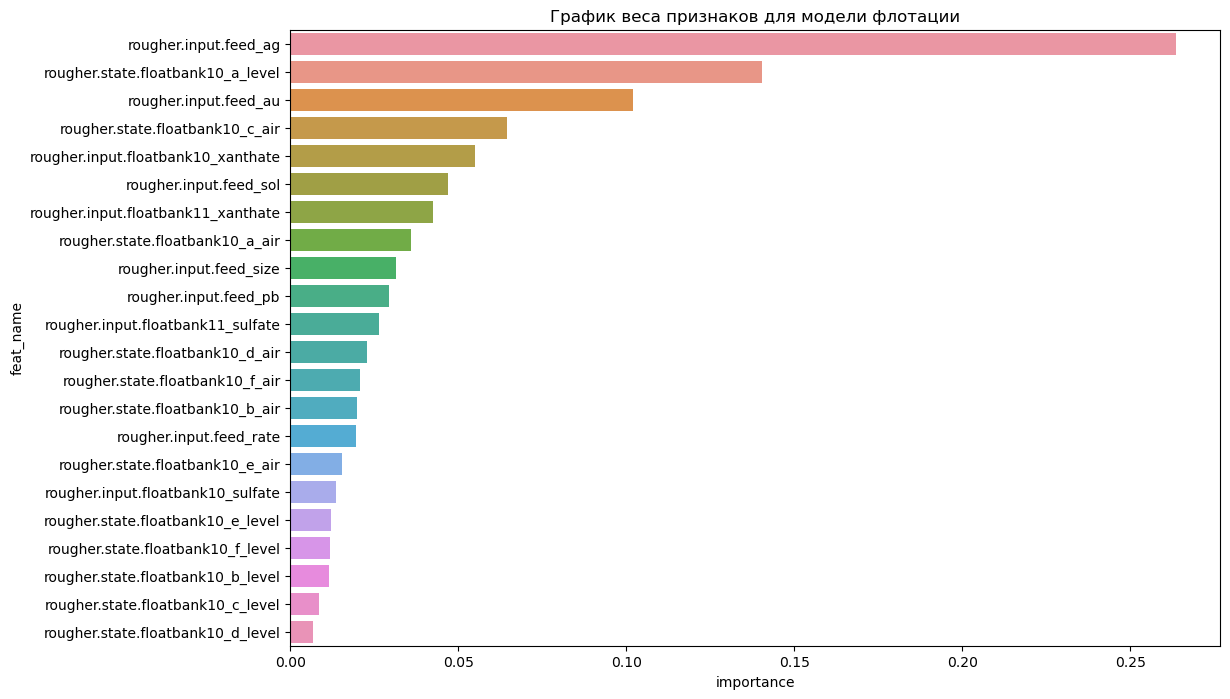

In [284]:
plt.figure(figsize=(12, 8))
sns.barplot(data=rougth_imp.sort_values(by='importance', ascending=False), y='feat_name', x='importance')
plt.title('График веса признаков для модели флотации');

In [285]:
importances_final = best_cleaner_model.named_steps['model'].feature_importances_
features_final_train_name = features_test_cleaner.columns
final_imp = pd.DataFrame()
final_imp['feat_name'] = features_final_train_name
final_imp['importance'] = importances_final


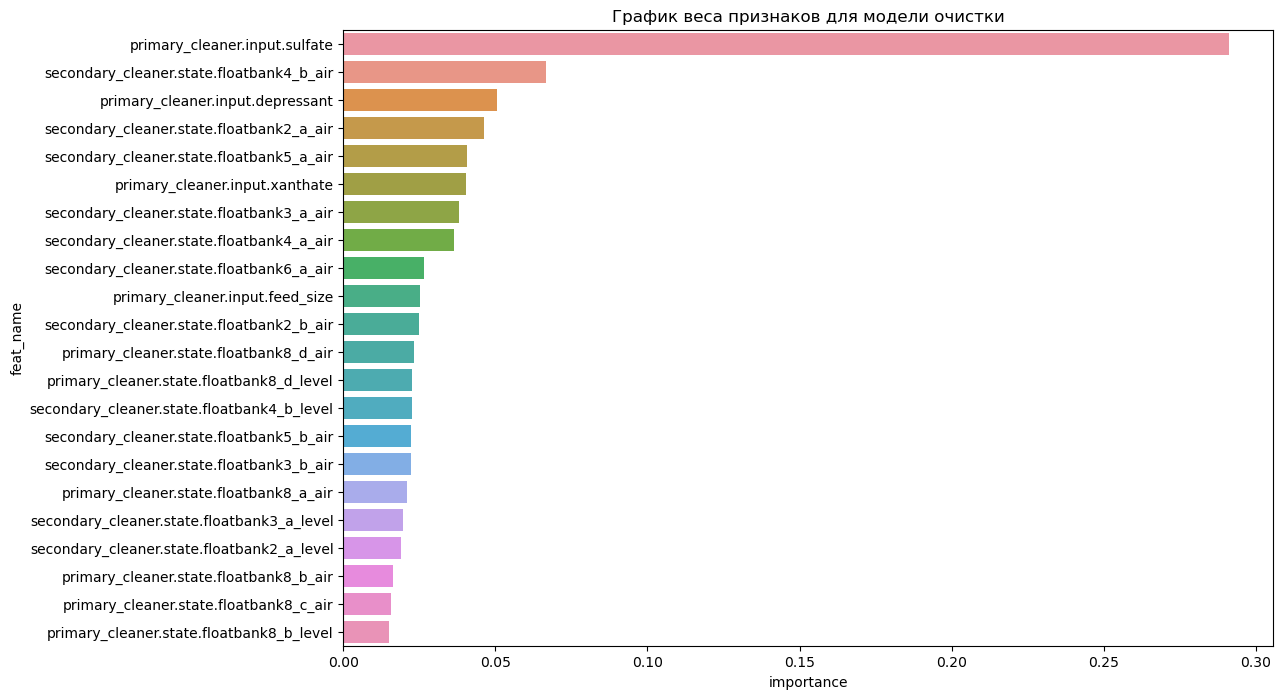

In [286]:
plt.figure(figsize=(12, 8))
sns.barplot(data=final_imp.sort_values(by='importance', ascending=False).head(22), y='feat_name', x='importance')
plt.title('График веса признаков для модели очистки');

Создадим графики предсказанных и истинных значений

In [287]:
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'red'])

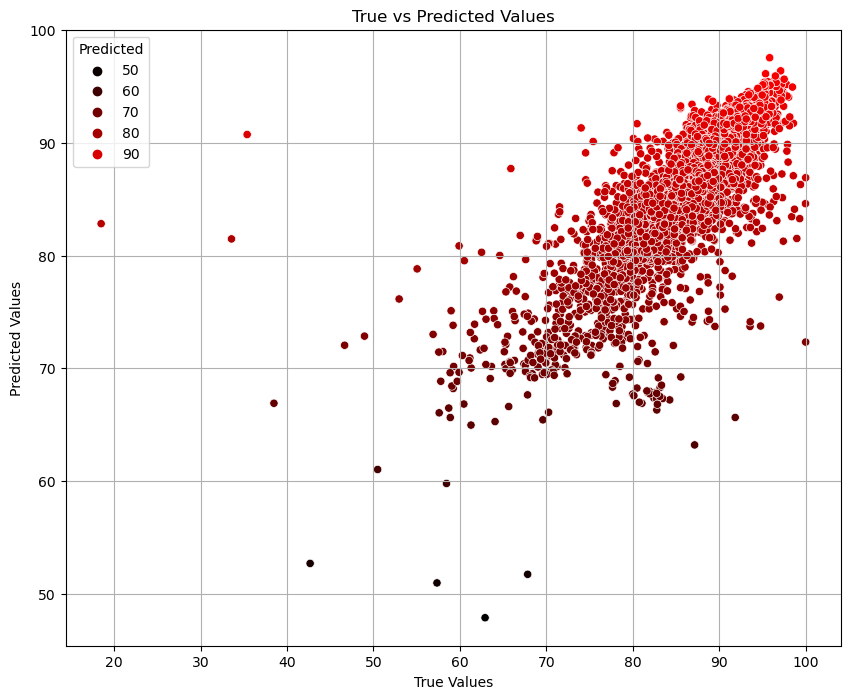

In [288]:
# Создаем DataFrame, содержащий истинные и предсказанные значения
rft_preds = pd.DataFrame({'True': target_test_rougher, 'Predicted': best_rougth_model.predict(features_test_rougher)})

# Создаем график
plt.figure(figsize=(10, 8))
sns.scatterplot(x='True', y='Predicted', hue='Predicted', data=rft_preds, palette=cmap)
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


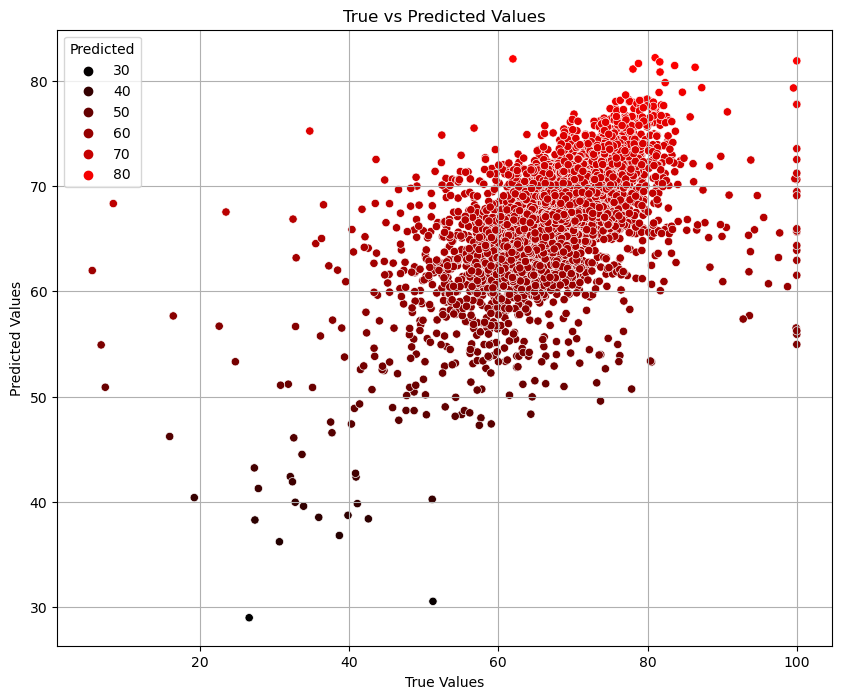

In [289]:
rft_preds = pd.DataFrame({'True': target_test_cleaner, 'Predicted': best_cleaner_model.predict(features_test_cleaner)})

# Создаем график
plt.figure(figsize=(10, 8))
sns.scatterplot(x='True', y='Predicted', hue='Predicted', data=rft_preds, palette=cmap)
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


In [290]:
df_smape.style.format('{:.02f}')

,sMAPE_rougher,sMAPE_cleaner,final_sMAPE
model,3.10,6.60,5.91
dummy_train,6.93,9.80,9.08
dummy_test,5.90,9.13,8.32


# Общий вывод

 - После пересчета и анализа данных, было выявлено, что значения recovery в сырых данных расчитано корректно
 
 - Из обучающего датасета были убраны признаки, своевременный мониториг которых недостаточно оперативен
 
 - Пропущенные значения были заполнены методом ffill.
 
 - Сравнительного анализ распределений обучающей и тестовой выборок показал, что будет корректно сопоставлять данные между выборками.
 
 - Лучшими моделями показали себя RandomForestRegressor с наилучшими показателями на тестовой выборке *SMAPE* в `3.10` для флотации, `6.60` для очистки и *final sMAPE* `5.91`.
 
 - Все модели прошли проверку на адекватность.